# Government Resolutions

This program imports two additional datasets:
1. Southern Poverty Law Center's [Hate Map](https://www.splcenter.org/hate-map) data on hate groups by year. 
2. Stop AAPI Hate's dataset of government resolutions opposing hate against Asian Americans and Pacific Islanders, as of as of August 2021 and accessed through their [50 State Survey](https://stopaapihate.org/resources/) in the Legislation and Policies section. This dataset contains resolutions passed at the federal, state, county, municipal, and school district levels.

First, we will download these two datasets and do some exploratory data analysis. We then merge them together, along with the FBI data on hate crime rates, read in and processed in another program. We merge in additional data such as political ideology by state and state population. We create classifier models using KNearestNeighbors and SVM to predict whether states passed a government resolution at the state level and whether any resolution was passed in the state.

In [1]:
# Imports

import pandas as pd
import numpy as np
import os
import plotly.express as px
from pandas.plotting import scatter_matrix

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('ggplot')

# Import seaborn & Apply the default theme
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split, cross_val_score


In [2]:
# pip install plotly-express

## Hate groups data
Read in data from the Southern Poverty Law Center's [Hate Map](https://www.splcenter.org/hate-map) page. This dataset contains information on hate groups by year. Each hate group has a separate record for chapters in different states.

In [3]:
# Folder where the raw data lives
folder = "Data/SPLC Hate Groups"

# Empty dataframe to hold all data
hategroups = pd.DataFrame(columns = ['Title', 'City', 'State', 'Group', 'Ideology', 'Headquarters', 'Statewide', 'Year'])

# Read in each file in the folder and save as one data frame
for filename in os.listdir(folder):
    pth = os.path.join(folder,filename)
    hategroups = hategroups.append(pd.read_csv(pth))
        

In [4]:
# Sort dataframe by year and state
hategroups = hategroups.sort_values(by=['Year', 'State', 'Title'])
hategroups.head()

Title        City    State Group       Ideology  \
4  Alabama White Knights of the KKK    Anniston  Alabama   NaN  Ku Klux Klan    
5  Alabama White Knights of the KKK  Birmingham  Alabama   NaN  Ku Klux Klan    
6  Alabama White Knights of the KKK     Clanton  Alabama   NaN  Ku Klux Klan    
7  Alabama White Knights of the KKK     Gadsden  Alabama   NaN  Ku Klux Klan    
8  Alabama White Knights of the KKK      Jasper  Alabama   NaN  Ku Klux Klan    

  Headquarters Statewide  Year  
4          NaN       NaN  2000  
5          NaN       NaN  2000  
6          NaN       NaN  2000  
7          NaN       NaN  2000  
8          NaN       NaN  2000

      Count
Year       
2000    599
2001    667
2002    705
2003    749
2004    761
2005    801
2006    841
2007    884
2008    926
2009    932
2010   1002
2011   1018
2012   1007
2013    939
2014    784
2015    892
2016    917
2017    954
2018   1020
2019    940
2020    838
2021    733


Text(0.5, 1.0, 'Number of Hate Crime Groups by Year')

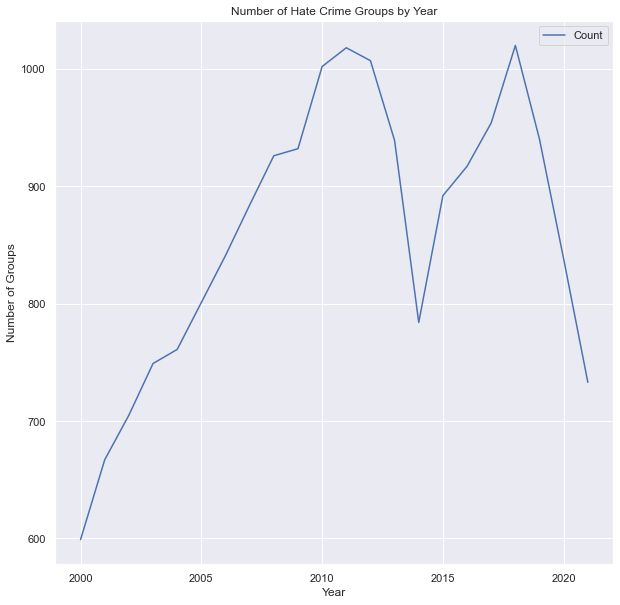

In [5]:
## Number of hate groups by year
yearly = hategroups.groupby("Year")
yearly_hategroups = yearly.count().sort_values("Year")
yearly_hategroups

# Change names and only keep counts
yearly_hategroups["Count"] = yearly_hategroups["Title"]
yearly_hategroups = yearly_hategroups[["Count"]]

print(yearly_hategroups)

# Plot
yearly_hategroups.plot()
plt.ylabel("Number of Groups")
plt.title("Number of Hate Crime Groups by Year")
#plt.xticks(np.arange(2000, 2022), rotation = 'vertical')

The number of hate groups by year increased from 599 in 2000 to 1018 in 2011. The number then dropped to 892 in 2014, rose again to 1020 in 2018, and dropped in recent years to 733 in 2021. The [Southern Poverty Law Center](https://www.splcenter.org/news/2019/02/19/hate-groups-reach-record-high) hypothesizes that the rise in hate groups beginning in 2014 was related to President Trump’s campaign and presidency, in which he "fan[ned] the flames of white resentment over immigration and the country’s changing demographics."

In [6]:
# Number of hate groups by year and by state
hategroups
statesum = hategroups.groupby(["Year", "State"], as_index=False)
stateyear_hategroups = statesum.count()
stateyear_hategroups

# Change names and only keep counts
stateyear_hategroups["Count"] = stateyear_hategroups["Title"]
stateyear_hategroups = stateyear_hategroups[["Year", "State", "Count"]]

print("Number of hate groups by year and state")
stateyear_hategroups

Number of hate groups by year and state


Year          State  Count
0     2000        Alabama     38
1     2000         Alaska      1
2     2000        Arizona      8
3     2000       Arkansas     18
4     2000     California     29
...    ...            ...    ...
1075  2021       Virginia     20
1076  2021     Washington     19
1077  2021  West Virginia      6
1078  2021      Wisconsin     12
1079  2021        Wyoming      2

[1080 rows x 3 columns]

In [7]:
# Download state abbreviations
stateabb = pd.read_csv("Data/Other data/StateAbbr.csv")
stateabb["State Code"] = stateabb["Code"]
stateabb = stateabb[["State", "State Code"]]
stateabb 

# Merge with state-year dataframe
stateyear_hategroups = stateyear_hategroups.merge(stateabb, how='left', on='State')

**Create state maps**

This article from [Towardsdatascience](https://towardsdatascience.com/simplest-way-of-creating-a-choropleth-map-by-u-s-states-in-python-f359ada7735e) was helpful in learning how to create U.S. choropleth maps using plotly.

Note: These maps may not save as output when the file is closed and re-opened. This code will have to be re-run to view the maps.

2020 Map

In [8]:
# Choropleth map for 2020
map2020 = stateyear_hategroups.loc[stateyear_hategroups["Year"]==2020]
print(map2020)

fig = px.choropleth(map2020,
                    locations='State Code', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Count',
                    color_continuous_scale="Inferno_r", 
                    )
fig.update_layout(
      title_text = 'Number of Hate Groups by State, 2020',
      # title_font_family="Calibri",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )

fig.show()

      Year                 State  Count State Code
978   2020               Alabama     20         AL
979   2020                Alaska      1         AK
980   2020               Arizona     26         AZ
981   2020              Arkansas     14         AR
982   2020            California     72         CA
983   2020              Colorado     17         CO
984   2020           Connecticut      6         CT
985   2020              Delaware      3         DE
986   2020  District of Columbia     19         DC
987   2020               Florida     68         FL
988   2020               Georgia     29         GA
989   2020                Hawaii      4         HI
990   2020                 Idaho      7         ID
991   2020              Illinois     19         IL
992   2020               Indiana     19         IN
993   2020                  Iowa      3         IA
994   2020                Kansas      2         KS
995   2020              Kentucky     13         KY
996   2020             Louisian

Interactive map for all years

In [9]:
# Interactive map for all years
stateyear_hategroups["Year"] = stateyear_hategroups["Year"].astype(str)

fig = px.choropleth(stateyear_hategroups,
                    locations='State Code', 
                    animation_frame="Year",
                    locationmode="USA-states", 
                    scope="usa",
                    color='Count',
                    color_continuous_scale="Inferno_r" 
                    )
fig.update_layout(
      title_text = 'Number of Hate Groups by State, 2000-2021',
      # title_font_family="Calibri",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )

fig.show()


Looking at the number of hate groups by state over the time period 2000-2021, hate groups were more concentrated in the south until 2010, when rates began to increase in the northeast. California, Texas and Florida consistently have the highest number of hate groups. 

Look at changes in hate group ideaology by year.

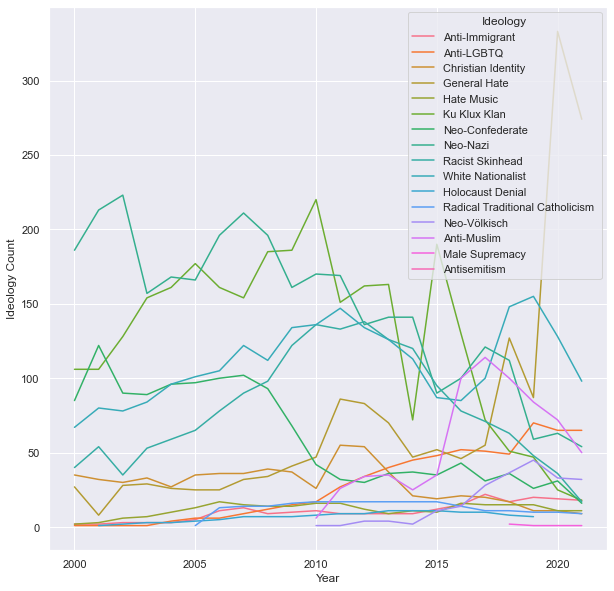

In [10]:
# Ideaology by year
hategroups["Ideology"].value_counts()

# Number of hate groups by Ideology by year
idea = hategroups.groupby(["Year", "Ideology"], as_index=False)
yearly_idea = idea.count().sort_values("Year")
yearly_idea

# Change names and only keep counts
yearly_idea["Ideology Count"] = yearly_idea["Title"]
yearly_idea = yearly_idea[["Year", "Ideology", "Ideology Count"]]
yearly_idea 

# Plot 
sns.lineplot(data=yearly_idea, x='Year', y='Ideology Count', hue='Ideology')
sns.set(rc = {'figure.figsize':(20,15)}) 

In [11]:
# Ideaology by year and state

# Number of hate groups by Ideology by year
stateidea = hategroups.groupby(["Year", "State", "Ideology"], as_index=False)
stateyear_idea = stateidea.count().sort_values("Year")
stateyear_idea

# Change names and only keep counts
stateyear_idea["Ideology Count"] = stateyear_idea["Title"]
stateyear_idea = stateyear_idea[["Year", "State", "Ideology", "Ideology Count"]]
stateyear_idea.head() 

Year     State             Ideology  Ideology Count
0    2000   Alabama  Christian Identity                3
111  2000  New York      Neo-Confederate               2
112  2000  New York             Neo-Nazi               9
113  2000  New York     Racist Skinhead                1
114  2000  New York   White Nationalist                4

## Resolutions by State

The organization Stop AAPI Hate put together a dataset of government resolutions opposing hate against Asian Americans and Pacific Islanders as of August 2021, which can be downloaded by clicking on [50 State Survey](https://stopaapihate.org/resources/) in the Legislation and Policies section. This dataset contains resolutions passed at the federal, state, county, municipal, and school district levels.

In [12]:
# State data
stateres = pd.read_excel("Data/Other data/Resolutions-By-Government-200831.xlsx", sheet_name="State", header=1)
stateres.rename(columns={"Level of \ngovernment": "Level of Government", "Date of \nEnactment": "Date of Enactment", "Current Status \n(if not enacted)": "Current Status", "Title of Resolution (Hyperlinked)": "Title of Resolution"}, inplace = True)

# Create variable indiciating if the state has a resolution
stateres["State Res"] = np.where(stateres["Title of Resolution"].str.contains("No published resolution against AAPI hate could be located"), 0, 1)
stateres.head()


# Level of Government     Location State Enacting body Date of Enactment  \
0   1               State   Montgomery    AL           NaN               NaT   
1   2               State       Juneau    AK           NaN               NaT   
2   3               State      Phoenix    AZ           NaN               NaT   
3   4               State  Little Rock    AR           NaN               NaT   
4  5a               State   Sacramento    CA      Assembly        2021-02-16   

  Current Status  \n(if not enacted)  \
0                                NaN   
1                                NaN   
2                                NaN   
3                                NaN   
4                                NaN   

                                 Title of Resolution  State Res  
0  No published resolution against AAPI hate coul...          0  
1  No published resolution against AAPI hate coul...          0  
2  No published resolution against AAPI hate coul...          0  
3  No published resolution against AAPI hate coul...          0  
4  A resolution denouncing hate crimes, hateful r...          1

In [13]:
# County data
countyres = pd.read_excel("Data/Other data/Resolutions-By-Government-200831.xlsx", sheet_name="County", header=1)
countyres.rename(columns={"Level of \ngovernment": "Level of Government", "Date of \nEnactment": "Date of Enactment", "Current Status \n(if not enacted)": "Current Status", "Title of Resolution (Hyperlinked)": "Title of Resolution"}, inplace = True)

# Create variable indiciating if the state has a resolution or a statement
countyres["County Res"] = np.where(countyres["Title of Resolution"].str.contains("No published resolution against AAPI hate could be located"), 0, 1)
countyres["County Statement"] = np.where(countyres["Non-Resolution Statements and Initiatives"].notnull(), 1, 0)

countyres[countyres["County Statement"]==1].head()


# Level of Government     Location State               Enacting body  \
214    215              County  San Joaquin    CA                         NaN   
216   217a              County    San Mateo    CA        Board of Supervisors   
1282  1282              County       Ottawa    MI       Board of Commisioners   
1820  1820              County     Dutchess    NY                         NaN   
1840  1840              County       Orange    NY  Commission on Human Rights   

        Date of Enactment Current Status  \n(if not enacted)  \
214                   NaN                                NaN   
216   2021-04-06 00:00:00                                NaN   
1282  2021-04-13 00:00:00                                NaN   
1820                  NaN                                NaN   
1840  2021-05-12 00:00:00                                NaN   

                                    Title of Resolution  \
214   No published resolution against AAPI hate coul...   
216   Resolution Condemning Hate Crimes Against Asia...   
1282  No published resolution against AAPI hate coul...   
1820  No published resolution against AAPI hate coul...   
1840  No published resolution against AAPI hate coul...   

              Non-Resolution Statements and Initiatives  County Res  \
214   Statement of Solidarity with the AAPI Communit...           0   
216   Earlier resolution enacted on 21-APR-2020: Res...           1   
1282                           Asian American Statement           0   
1820  DCCHR Statement on the murders in Atlanta targ...           0   
1840  Speaker Series: Anti-Asian Hate: Covid, Asians...           0   

      County Statement  
214                  1  
216                  1  
1282                 1  
1820                 1  
1840                 1

In [14]:
# Municipal
municres = pd.read_excel("Data/Other data/Resolutions-By-Government-200831.xlsx", sheet_name="Municipal", header=1)
municres.rename(columns={"Level of \ngovernment": "Level of Government", "Date of \nEnactment": "Date of Enactment", "Current Status \n(if not enacted)": "Current Status", "Title of Resolution (Hyperlinked)": "Title of Resolution"}, inplace = True)

# Create variable indiciating if the state has a resolution or a statement
municres["Municipal Res"] = np.where(municres["Title of Resolution"].str.contains("No published resolution against AAPI hate could be located"), 0, 1)
municres["Municipal Statement"] = np.where(municres["Non-Resolution Statements and Initiatives"].notnull(), 1, 0)

municres[municres["Municipal Statement"]==1].head()


#      Level           Location State Enacting body  \
136  138  Municipal   Aliso Viejo city    CA  City Council   
165  167  Municipal    Buena Park city    CA  City Council   
194  196  Municipal    Costa Mesa city    CA           NaN   
257  259  Municipal        Irvine city    CA  City Council   
272  274  Municipal  Laguna Woods city    CA  City Council   

       Date of Enactment Current Status  \
136  2021-05-19 00:00:00            NaN   
165  2021-04-07 00:00:00            NaN   
194                  NaN            NaN   
257  2020-04-19 00:00:00            NaN   
272  2020-04-07 00:00:00            NaN   

                                   Title of Resolution  \
136                                Resolution No. 2021   
165  RESOLUTION OF THE CITY COUNCIL OF THE CITY OF ...   
194  No published resolution against AAPI hate coul...   
257  Resolution of the City Council of the City of ...   
272  Proclamation of the City of Laguna Woods Denou...   

             Non-Resolution Statements and Initiatives Unnamed: 9  \
136  Proclamation Asian Pacific American Heritage M...        NaN   
165  Proclamation Declaring May 2021 Asian American...        NaN   
194  Proclamation: Asian American Pacific Islander ...        NaN   
257  Proclamation asian American and Pacific Island...        NaN   
272  Proclamation Asian American and Pacific Island...        NaN   

     Municipal Res  Municipal Statement  
136              1                    1  
165              1                    1  
194              0                    1  
257              1                    1  
272              1                    1

Sum the county and municipal datasets to the state level. For each state, we want to know how many resolutions/statements were passed, saved in the variable "Total Res" and whether any resolution or statement was passed in the state, saved in the variable "Any Res".

In [15]:
# For some reason, RI is missing from the county file (but not state or municipal). Add in a value of 0 so that it doesn't turn into NA in the merge
countyres = countyres.append({'State': "RI", "County Res":0, "County Statement":0}, ignore_index=True)
countyres["State"].value_counts().sort_index()
countyres[countyres["State"]=="RI"]

# Merge state, county and municipal
statesummary = stateres.groupby("State", as_index=False).sum().merge(countyres.groupby("State", as_index=False).sum().merge(municres.groupby("State", as_index=False).sum(), how='left', on='State'),how='left', on='State')
statesummary = statesummary.drop(columns="#")


# Add in variable that is any state, county, or municipal resolution
statesummary["Total Res"] = statesummary.sum(axis=1, numeric_only=True)
statesummary["Any Res"] = np.where(statesummary["Total Res"]>0, 1, 0)
statesummary



State  State Res  County Res  County Statement  Municipal Res  \
0     AK          0           1                 0              1   
1     AL          0           0                 0              0   
2     AR          0           1                 0              1   
3     AZ          0           0                 0              0   
4     CA          2          20                 2             62   
5     CO          0           1                 0              1   
6     CT          0           0                 0              1   
7     DE          1           0                 0              0   
8     FL          1           1                 0              8   
9     GA          1           2                 0              3   
10    HI          1           0                 0              0   
11    IA          0           1                 0              0   
12    ID          0           0                 0              0   
13    IL          0           2                 0              3   
14    IN          1           0                 0              1   
15    KS          0           0                 0              0   
16    KY          0           0                 0              0   
17    LA          0           2                 0              0   
18    MA          1           0                 0              3   
19    MD          0           2                 0              0   
20    ME          0           0                 0              0   
21    MI          2           5                 1              4   
22    MN          1           1                 0              3   
23    MO          0           1                 0              3   
24    MS          0           0                 0              0   
25    MT          0           0                 0              0   
26    NC          0           1                 0              2   
27    ND          1           0                 0              0   
28    NE          1           0                 0              0   
29    NH          0           0                 0              0   
30    NJ          2           1                 0              2   
31    NM          0           0                 0              0   
32    NV          0           1                 0              0   
33    NY          0           2                 3              0   
34    OH          2           1                 0              4   
35    OK          1           0                 0              0   
36    OR          0           1                 3              1   
37    PA          0           0                 0              1   
38    RI          2           0                 0              3   
39    SC          0           1                 1              0   
40    SD          0           0                 0              0   
41    TN          1           1                 0              1   
42    TX          1           1                 0              2   
43    UT          1           0                 0              0   
44    VA          0           2                 0              1   
45    VT          1           0                 0              1   
46    WA          1           1                 1             15   
47    WI          1           5                 0              7   
48    WV          1           0                 0              0   
49    WY          0           0                 0              0   

    Municipal Statement  Total Res  Any Res  
0                     0          2        1  
1                     0          0        0  
2                     0          2        1  
3                     0          0        0  
4                    12         98        1  
5                     0          2        1  
6                     0          1        1  
7                     1          2        1  
8                     0         10        1  
9                     1          7        1  
10                    0     

In [16]:
print(statesummary["Any Res"].value_counts())
print(statesummary["State Res"].value_counts())

statesummary.describe()

1    41
0     9
Name: Any Res, dtype: int64
0    28
1    17
2     5
Name: State Res, dtype: int64


State Res  County Res  County Statement  Municipal Res  \
count  50.000000   50.000000         50.000000      50.000000   
mean    0.540000    1.160000          0.220000       2.680000   
std     0.676425    2.937165          0.678835       8.956676   
min     0.000000    0.000000          0.000000       0.000000   
25%     0.000000    0.000000          0.000000       0.000000   
50%     0.000000    0.500000          0.000000       0.500000   
75%     1.000000    1.000000          0.000000       2.000000   
max     2.000000   20.000000          3.000000      62.000000   

       Municipal Statement  Total Res    Any Res  
count            50.000000  50.000000  50.000000  
mean              1.080000   5.680000   0.820000  
std               2.522066  14.292056   0.388088  
min               0.000000   0.000000   0.000000  
25%               0.000000   1.000000   1.000000  
50%               0.000000   2.000000   1.000000  
75%               1.000000   5.000000   1.000000  
max              13.000000  98.000000   1.000000

## Merge together all the data sets

In [17]:
# Re-name hate group variables and only keep 2020 data to merge
stateyear_hategroups.rename(columns={"State": "Statefull", "Count": "Number of hate groups", "State Code": "State"}, inplace=True)
hategroups2020 = stateyear_hategroups.loc[stateyear_hategroups["Year"]=="2020"]
# hategroups2020

Read in hate crime data from the FBI data. Raw data was read in and processed in an earlier program.

In [18]:
# Read in FBI data. This file was created in the program ADD PROGRAM NAME
fbi = pd.read_csv("Data/aapi_by_state.csv")

# Add variable that is 5 year change (2020 rate / 2015 rate). A value of 1 means no change.
# This gives some trouble for the handful of states with 0 hate crimes in 2015 (HI, MS, NE, WY). Replace these values with 0 rate of change
fbi["Hate Crimes 2015"] = fbi["State Crime Totals in 2020"] - fbi["Crimes in 2020-Crimes in 2015"]
fbi["Hate Crime 5 Year Change Rate"] = np.where(fbi["Hate Crimes 2015"]==0, 0, fbi["State Crime Totals in 2020"] / fbi["Hate Crimes 2015"])

# Drop observations from state = "Unknown", "GM", and "FS"
fbi = fbi.loc[fbi["State"] != "Unknown"]
fbi = fbi.loc[fbi["State"] != "GM"]
fbi = fbi.loc[fbi["State"] != "FS"]

#fbi


Read in state population estimates from 2020 and 2021, from the [Census Bureau](https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html#par_textimage_1574439295).

In [19]:
statepop = pd.read_excel("Data/Other data/NST-EST2021-POP.xlsx", header=3, nrows=51, sheet_name="NST-EST2021-POP")
statepop.rename(columns={"Geographic Area": "Statefull"}, inplace=True)
statepop["Statefull"] = statepop["Statefull"].str.replace(".", "", regex=False)
statepop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Statefull                     51 non-null     object
 1   April 1, 2020 Estimates Base  51 non-null     int64 
 2   Pop2020                       51 non-null     int64 
 3   Pop2021                       51 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.7+ KB


Read in data on political ideaology state from a 2018 [Gallup poll](https://news.gallup.com/poll/247016/conservatives-greatly-outnumber-liberals-states.aspx). Conservative advantage measures Conservative percent minus Liberal percent, without taking the percent Moderate into account.

In [20]:
# Read in data and rename columns
pol = pd.read_excel("Data/Other data/State Political Ideaology.xlsx", header=1, nrows=51)
pol.rename(columns={"Unnamed: 0": "Statefull"}, inplace=True)

# Drop empty rows and columns we don't need
pol = pol.loc[pol["Statefull"].isnull()==False]
pol.drop(columns=["N"], inplace=True)

# Convert percentages to (0,1) rather than (0,100)
pol["Conservative"] = (pol["Conservative"]/100).astype(float)
pol["Moderate"] = (pol["Moderate"]/100).astype(float)
pol["Liberal"] = (pol["Liberal"]/100).astype(float)
pol["Conservative advantage"] = (pol["Conservative advantage"]/100).astype(float)

# Convert variables to floats
pol.info()
#pol

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 1 to 50
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Statefull               50 non-null     object 
 1   Conservative            50 non-null     float64
 2   Moderate                50 non-null     float64
 3   Liberal                 50 non-null     float64
 4   Conservative advantage  50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.3+ KB


Merge together the three main datasets (resolutions, hate groups, FBI hate crimes) plus the two additional ones (political ideaology and state population).

In [21]:
# Check for duplicates
#stateyear_hategroups["State"].loc[stateyear_hategroups["Year"]=="2020"].value_counts()

# Merge all 3 datasets together
# Merge FBI and hate groups
temp = pd.merge(fbi, hategroups2020, left_on="State", right_on="State", how="outer")

# Add in resolutions
statehate = pd.merge(temp, statesummary, left_on="State", right_on="State", how="outer")
statehate.drop(columns = ["Year"], inplace=True)

# Add in state 2020 populations
statehate = pd.merge(statehate, statepop[["Statefull", "Pop2020"]], left_on="Statefull", right_on="Statefull", how="outer")

# Add in political ideaology
statehate = pd.merge(statehate, pol, left_on="Statefull", right_on="Statefull", how="outer")


# Create per capita measures

# Total hate crimes per 100,000 people
statehate["Hate crimes per cap"] = statehate["State Crime Totals in 2020"] / statehate["Pop2020"] * 100000

# Hate crimes against AAPI per 100,000 people
statehate["Hate crimes AAPI per cap"] = statehate["AAPI Crime Totals"] / statehate["Pop2020"] * 100000

# Number of hate groups per 100,000 people
statehate["Hate groups per cap"] = statehate["Number of hate groups"] / statehate["Pop2020"] * 100000

# State res shows the number of state resolutions, which is 2 for a few states where different state bodies (i.e. State Sentate and House) passed separate measures
# Create a variable called "Any State Res" that is 0/1 
statehate["Any State Res"] = np.where(statehate["State Res"] == 0, 0, 1)

# There is no resolution or political data for DC. Drop DC
statehate = statehate.loc[statehate["State"] != "DC"]

# Check data
statehate
# print(list(statehate.columns))



State  State Crime Totals in 2020  Crimes Committed by White Groups Totals  \
0     AL                          27                                        9   
1     AK                          10                                        4   
2     AZ                         282                                      152   
3     AR                          50                                       26   
4     CA                        1339                                      500   
5     CO                         283                                      157   
6     CT                         101                                       50   
7     DE                          13                                        3   
8     FL                         109                                       52   
9     GA                         253                                       80   
10    HI                          36                                        7   
11    ID                          48                                       24   
12    IL                          61                                       33   
13    IN                         187                                       86   
14    IA                          21                                        9   
15    KS                         124                                       68   
16    KY                         167                                       74   
17    LA                          62                                       26   
18    ME                          85                                       41   
19    MD                          40                                       11   
20    MA                         389                                      141   
21    MI                         420                                      191   
22    MN                         194                                       65   
23    MS                          36                                       15   
24    MO                         134                                       58   
25    MT                          26                                        7   
26    NE                         100                                       47   
27    NV                         148                                       71   
28    NH                          30                                        9   
29    NJ                        1428                                      322   
30    NM                          65                                       40   
31    NY                         465                                       97   
32    NC                         346                                      130   
33    ND                          22                                        6   
34    OH                         557                                      184   
35    OK                          58                                       23   
36    OR                         280                                      121   
37    PA                          83                                       23   
38    RI                          14                                        3   
39    SC                         123                                       46   
40    SD                          17                                        5   
41    TN                         134                                       59   
42    TX                         556                                      265   
43    UT                          54                                       22   
44    VT                          77                                       21   
45    VA                         187                                       56   
46    WA                         451                                      173   
47    WV                          82                                       49   
48    WI                         1

0    28
1    22
Name: Any State Res, dtype: int64
1.0    41
0.0     9
Name: Any Res, dtype: int64


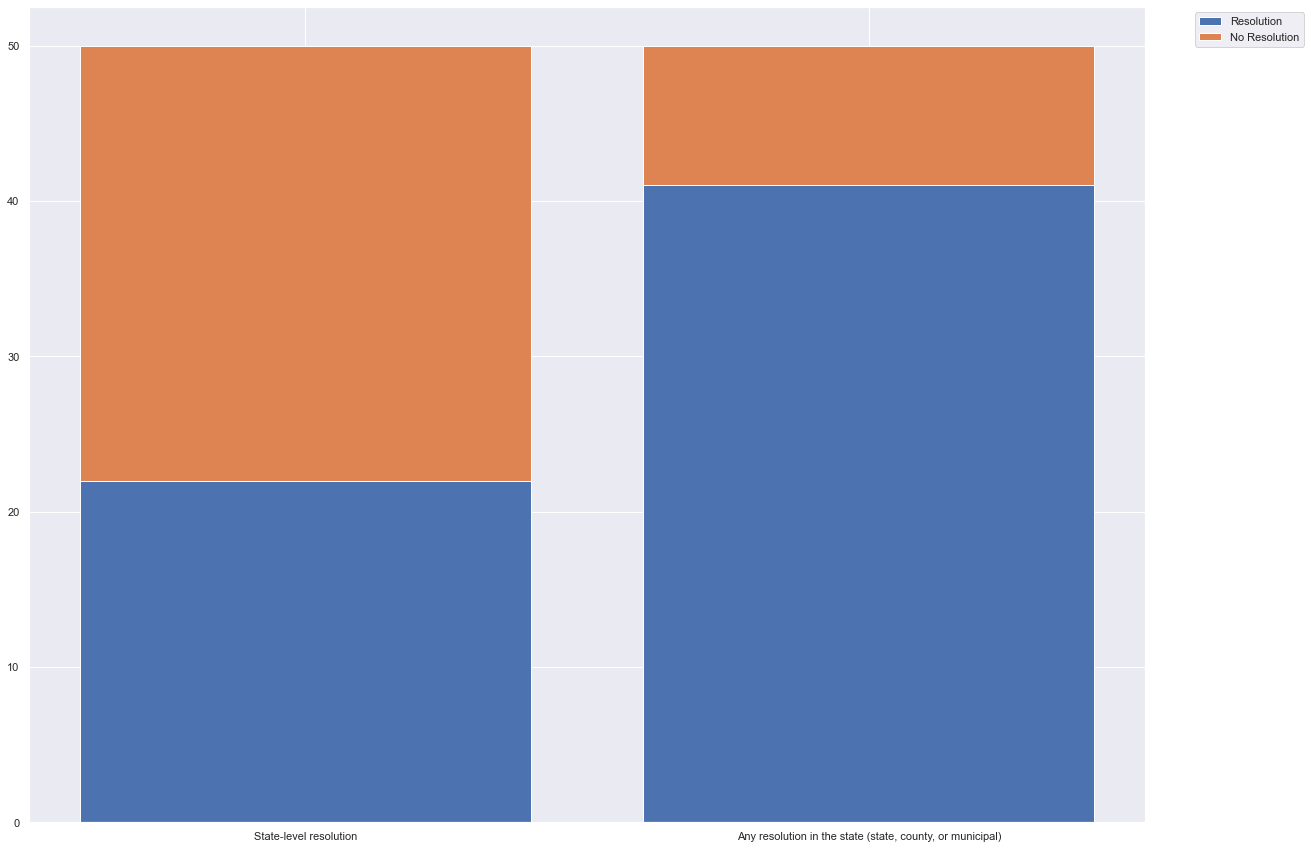

In [22]:
print(statehate["Any State Res"].value_counts())
print(statehate["Any Res"].value_counts())


plt.bar([1,2], [22,41], label="Resolution")
plt.bar([1,2], [28,9], bottom = [22,41], label = "No Resolution")
plt.xticks(ticks=[1,2], labels=["State-level resolution", "Any resolution in the state (state, county, or municipal)"])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

**Scatter plot matrix** to visualize the different datapoints

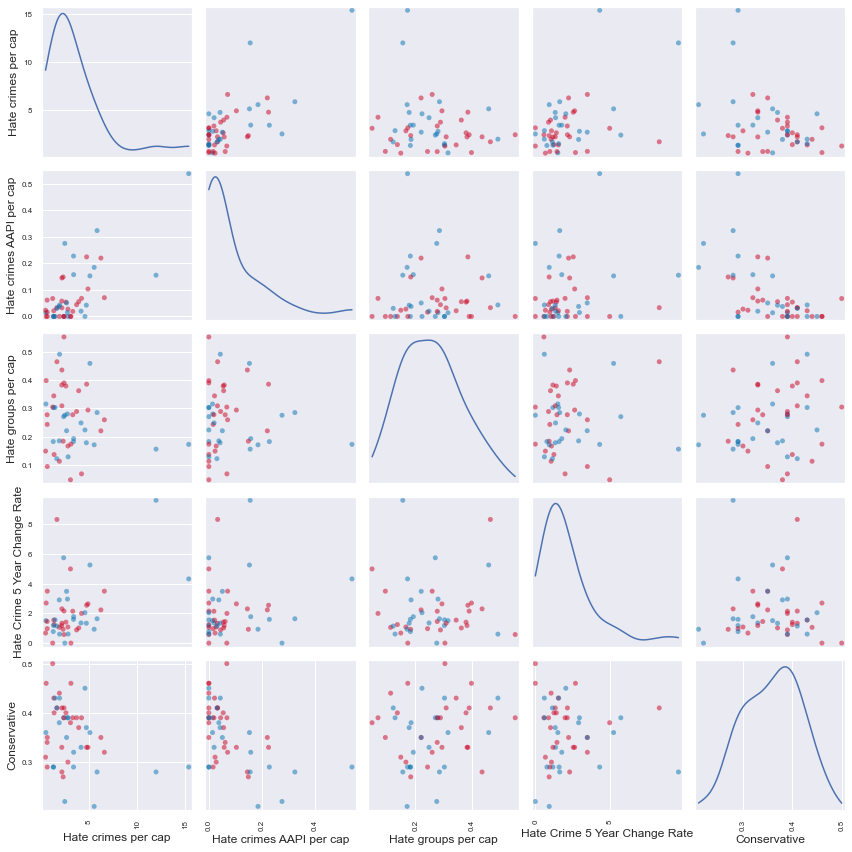

In [23]:
color_list=statehate["Any State Res"].map({0:"#ca0020", 1:"#0571b0"})

# Change default figure size back 
plt.rcParams['figure.figsize'] = (12, 12)

g = scatter_matrix(statehate[["Hate crimes per cap", "Hate crimes AAPI per cap", "Hate groups per cap", "Hate Crime 5 Year Change Rate", "Conservative"]], diagonal="kde", color=color_list, s=100)
plt.tight_layout()
print()

**PCA** to visualize the states 

(50, 6)
[0.47837275 0.20644609 0.16079305 0.10864924 0.03210347 0.0136354 ]


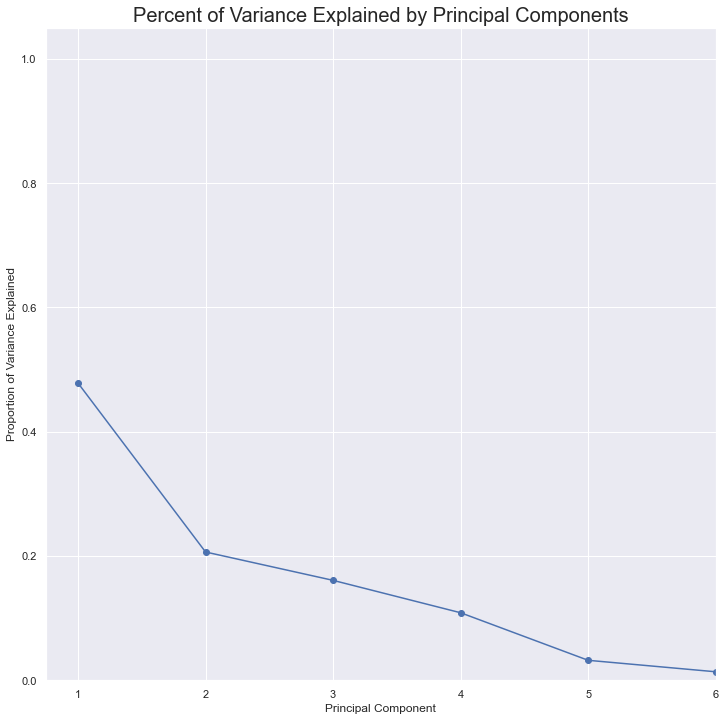

In [24]:
# "State Res", "Any Res", 
#X = scale(statehate[["Hate crimes per cap", "Hate crimes AAPI per cap", "Hate groups per cap", "Hate Crime 5 Year Change Rate", "Conservative"]].values)

X = scale(statehate[["Hate crimes per cap", "Hate crimes AAPI per cap", "Hate groups per cap", "Hate Crime 5 Year Change Rate", "Conservative", "Liberal"]].values)

# Calculate the principal components 
pca_model = PCA()
X_PCA = pca_model.fit_transform(X)
print(X_PCA.shape)

# Store the principal components in a pandas dataframe.
df_pca = pd.DataFrame(X_PCA, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

# Variance ratio of the four principal components
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)

# Plot
plt.plot([1,2,3,4,5,6], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4,5,6])
plt.title("Percent of Variance Explained by Principal Components", fontsize=20)
plt.show()


Plot states in 2-dimensions and in 1-dimension. Since the first principal component contains nearly 50% of the explained variance ratio, check the data in 1-dimension.

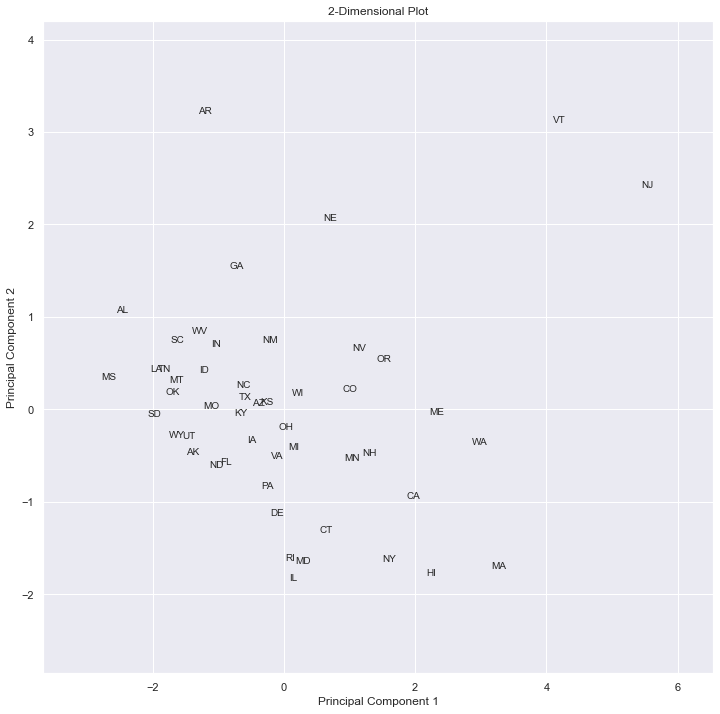

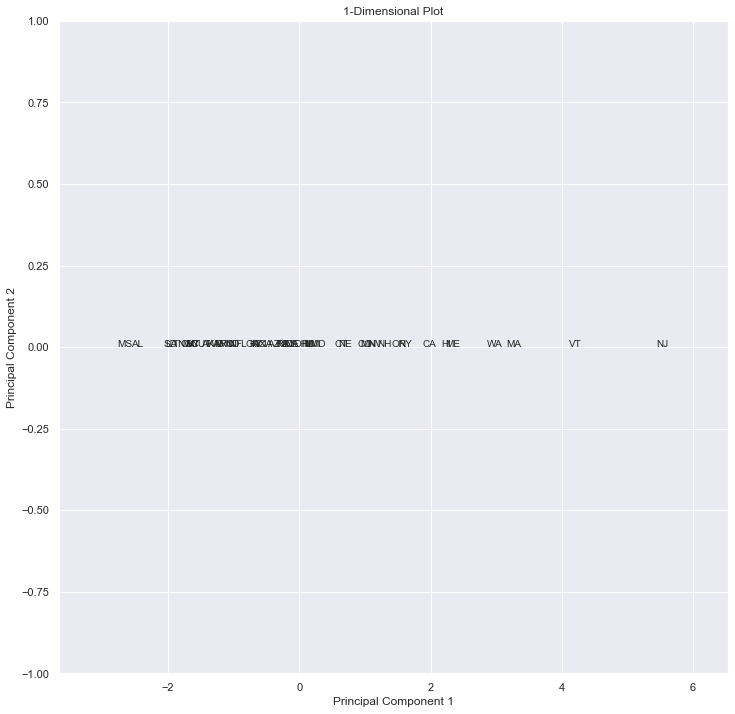

In [25]:
#Plot 2-dimmensions
fig,ax1 = plt.subplots()

# Set axis scales
ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)

for i,name in enumerate(statehate['State'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)

# plot using PCA
#plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred,s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("2-Dimensional Plot")
plt.show()


#Plot 1-dimension
fig,ax1 = plt.subplots()

# Set axis scales
ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(-1,1)

for i,name in enumerate(statehate['State'].values):
    ax1.annotate(name, (X_PCA[i,0], 0), ha='center',fontsize=10)

# plot using PCA
#plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred,s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("1-Dimensional Plot")
plt.show()

New Jersey seems to be an outlier. We will run models with and without New Jersey.

## Create a cluster heat map with a dendrogram using seaborn. 
Standardize variables.

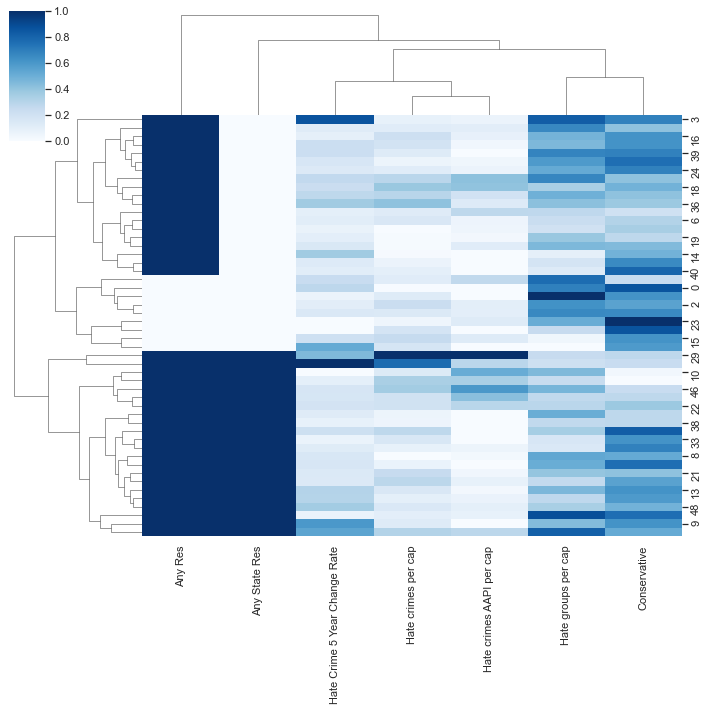

In [26]:
# statehate.info()

# statehate[["State", "Hate crimes per cap", "Hate crimes AAPI per cap", "Hate groups per cap", "Hate Crime 5 Year Change Rate", "State Res", "Any Res", "Conservative"]].describe()
d = sns.clustermap(statehate[["Hate crimes per cap", "Hate crimes AAPI per cap", "Hate groups per cap", "Any State Res", "Any Res", "Hate Crime 5 Year Change Rate", "Conservative"]], standard_scale=1,  method="complete", metric="euclidean", cmap="Blues")



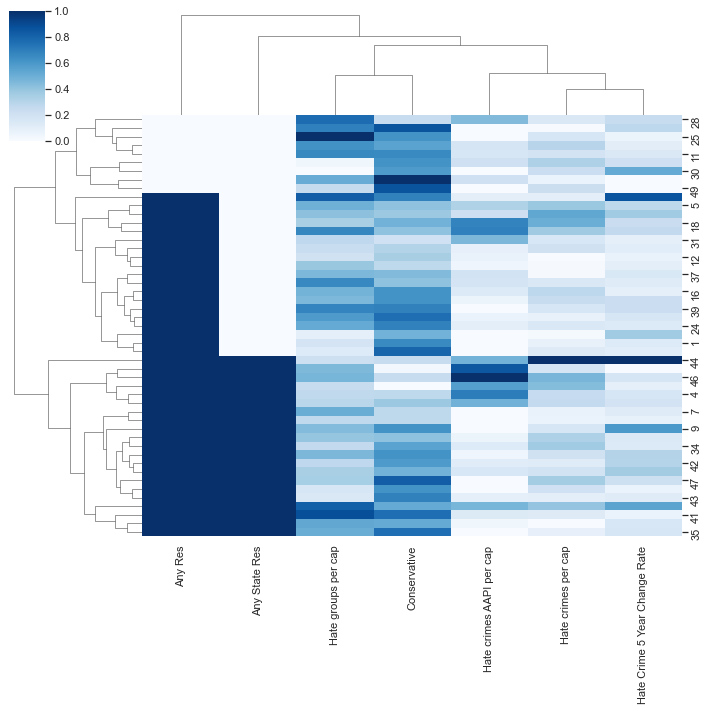

In [27]:
# And without New Jersey because it is an outlier 
statehate_2 = statehate.loc[statehate["State"] != "NJ"]

# statehate[["State", "Hate crimes per cap", "Hate crimes AAPI per cap", "Hate groups per cap", "Hate Crime 5 Year Change Rate", "State Res", "Any Res", "Conservative"]].describe()
d = sns.clustermap(statehate_2[["Hate crimes per cap", "Hate crimes AAPI per cap", "Hate groups per cap", "Any State Res", "Any Res", "Hate Crime 5 Year Change Rate", "Conservative"]], standard_scale=1,  method="complete", metric="euclidean", cmap="Blues")


# Classification

For classification, we use the scaled dataset X.

**SVM**

Outcome: State resolution. This means that the state body passed at least one resolution against AAPI hate at the state level.

Max accuracy: C = 11.08 Accuracy = 0.6


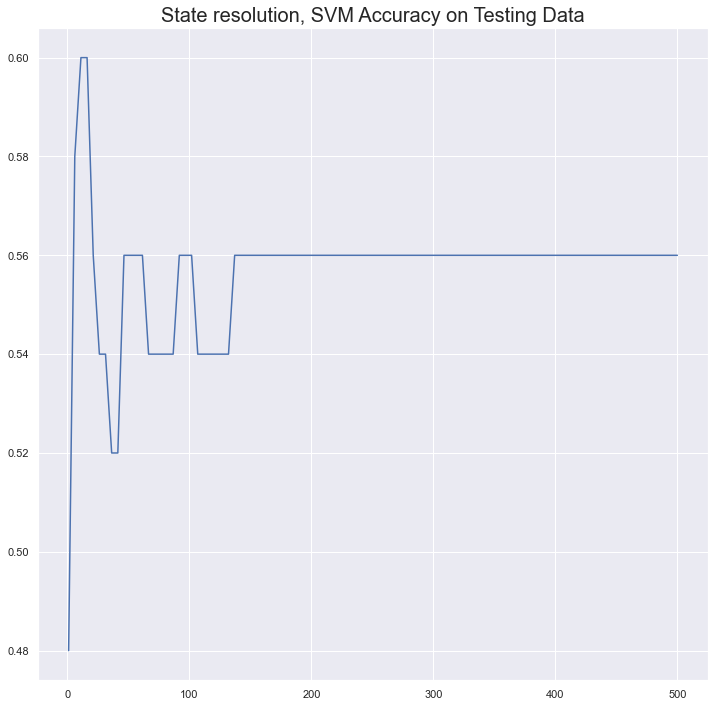

In [28]:
# Use an outcome of any state resolution
y = statehate["Any State Res"]

# Try different values of C
Cs = np.linspace(1,500,100)
# print(Cs)

# Using the 'cross_val_score' function, evaluate the accuracy of the SVM for different values of the parameter C.
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    svm_digits = svm.SVC(kernel='rbf', C = C, gamma='scale')
    scores = cross_val_score(estimator = svm_digits, X = X, y = y, cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
    
    #print(round(C), scores.mean())
     
# Print max value of C and accuracy score
print("Max accuracy: C =", round(Cs[np.argmax(Accuracies)], 2), "Accuracy =", round(np.max(Accuracies),2))

# Plot accuracies
plt.plot(Cs,Accuracies)
plt.title("State resolution, SVM Accuracy on Testing Data", fontsize=20)
plt.show()



Outcome: any resolution in the state (at any level of government)

Max accuracy: C = 1.0 Accuracy = 0.8


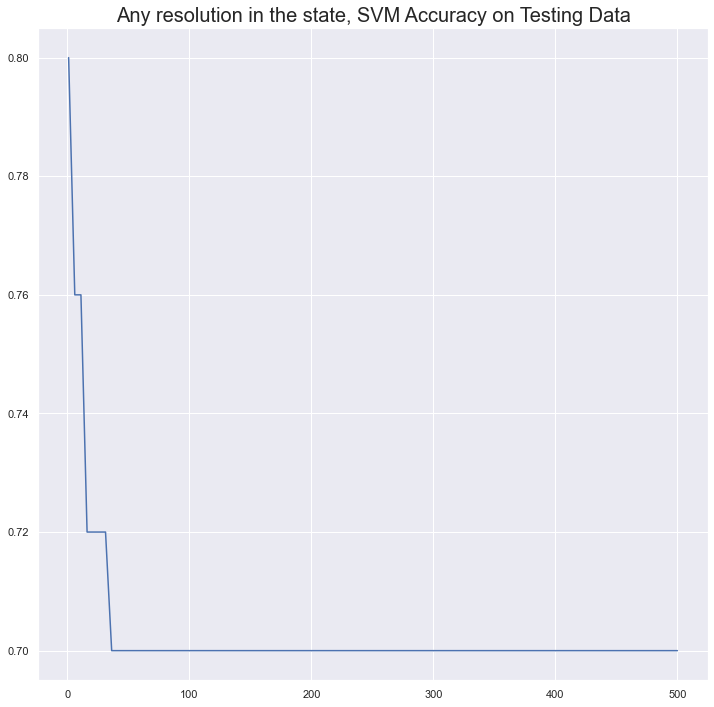

In [29]:
# Use an outcome of any resolution (at any level of government)
y = statehate["Any Res"]

# Try different values of C
Cs = np.linspace(1,500,100)
# print(Cs)

# Save the accuracies
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    svm_digits = svm.SVC(kernel='rbf', C = C, gamma='scale')
    scores = cross_val_score(estimator = svm_digits, X = X, y = y, cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
    
    #print(round(C), scores.mean())
     
# Print max value of C and accuracy score
print("Max accuracy: C =", round(Cs[np.argmax(Accuracies)], 2), "Accuracy =", round(np.max(Accuracies),2))

# Plot accuracies
plt.plot(Cs,Accuracies)
plt.title("Any resolution in the state, SVM Accuracy on Testing Data", fontsize=20)
plt.show()


**KNearestNeighbors**

Outcome: State resolution. This means that the state body passed at least one resolution against AAPI hate at the state level.

Max accuracy: k = 5 Accuracy = 0.6


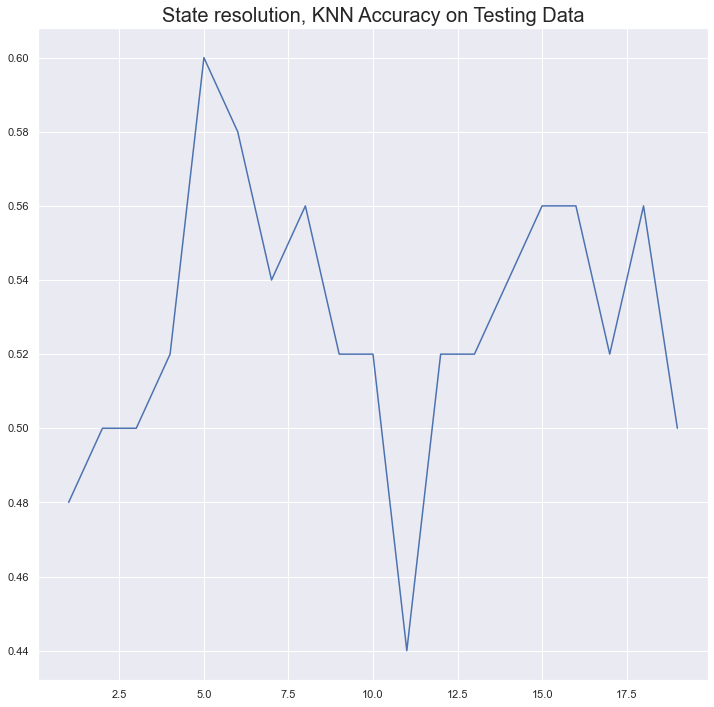

In [30]:
# Use an outcome of any state resolution
y = statehate["Any State Res"]

# Try different values of k
Ks = np.arange(1,20)
Accuracies = np.zeros(len(Ks))

# Save accuracies 
Accuracies = np.zeros(Ks.shape[0])
for i,k in enumerate(Ks): 
    ks_model = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(estimator = ks_model, X = X, y = y, cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
# Print value of k wiyh the highest  accuracy score
print("Max accuracy: k =", round(Ks[np.argmax(Accuracies)], 2), "Accuracy =", round(np.max(Accuracies),2))
        
# Plot all values
plt.plot(Ks,Accuracies)
plt.title("State resolution, KNN Accuracy on Testing Data", fontsize=20)
plt.show()

Outcome: any resolution in the state (at any level of government)

Max accuracy: k = 7 Accuracy = 0.82


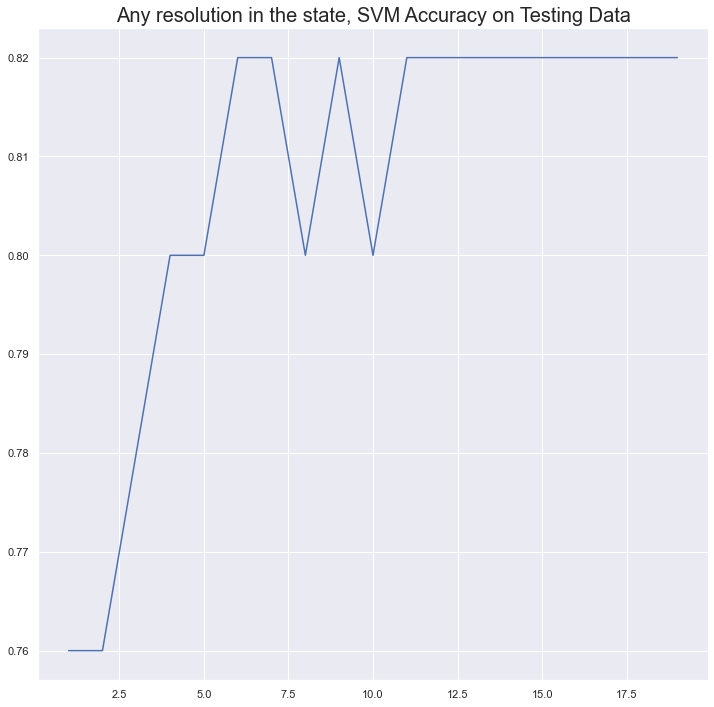

In [31]:
# Use an outcome of any resolution (at any level of government)
y = statehate["Any Res"]

# Try different values of k
Ks = np.arange(1,20)
Accuracies = np.zeros(len(Ks))

Accuracies = np.zeros(Ks.shape[0])
for i,k in enumerate(Ks): 
    ks_model = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(estimator = ks_model, X = X, y = y, cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
# Print value of k wiyh the highest  accuracy score
print("Max accuracy: k =", round(Ks[np.argmax(Accuracies)], 2), "Accuracy =", round(np.max(Accuracies),2))
        
# Plot all values
plt.plot(Ks,Accuracies)
plt.title("Any resolution in the state, SVM Accuracy on Testing Data", fontsize=20)
plt.show()

**Interpretation:** With the outcome of any state resolution, meaning the state body passed at least one resolution against AAPI hate at the state level, the SVM classifier has a maximum accuracy score 0.6 with c = 11.08 and the KNearestNeighbors also has a maximum accuracy of 0.6 with k = 5. This is not a great accuracy, as it is not that far above 50%, whch is the accuracy if the outcome was chosen at random.

With the outcome of any resolution in the state (at any level of government), the SVM classified has a maximum accuracy of 0.8 with c = 1.0 and the KNearestNeighbors has a maximum accuracy 0.82 with k = 7. The performance of both classifiers is much better with this outcome.

## Remove the outlier
Try the same classification models without the outlier, NJ

SVM

SVM: Any state resolution
Max accuracy: C = 6.04 Accuracy = 0.57


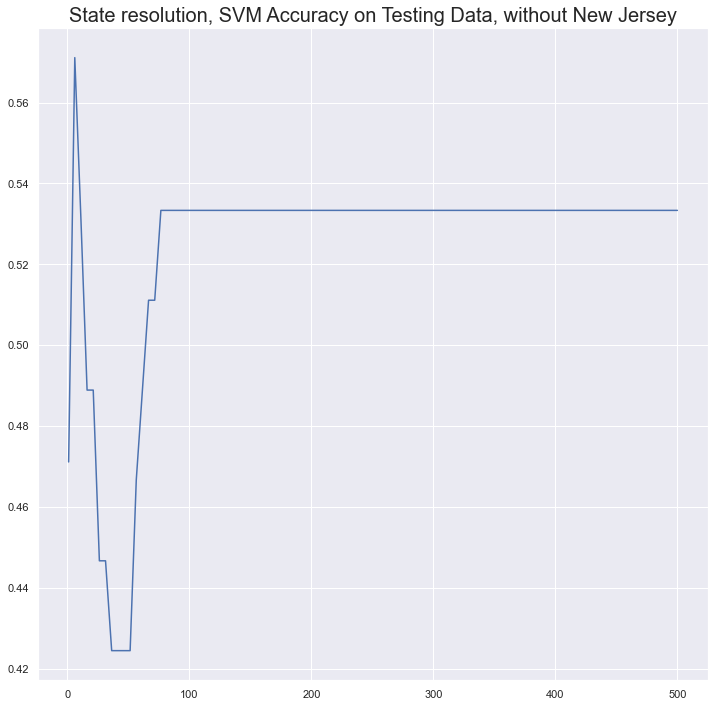

SVM: Any resolution at any level of government
Max accuracy: C = 1.0 Accuracy = 0.8


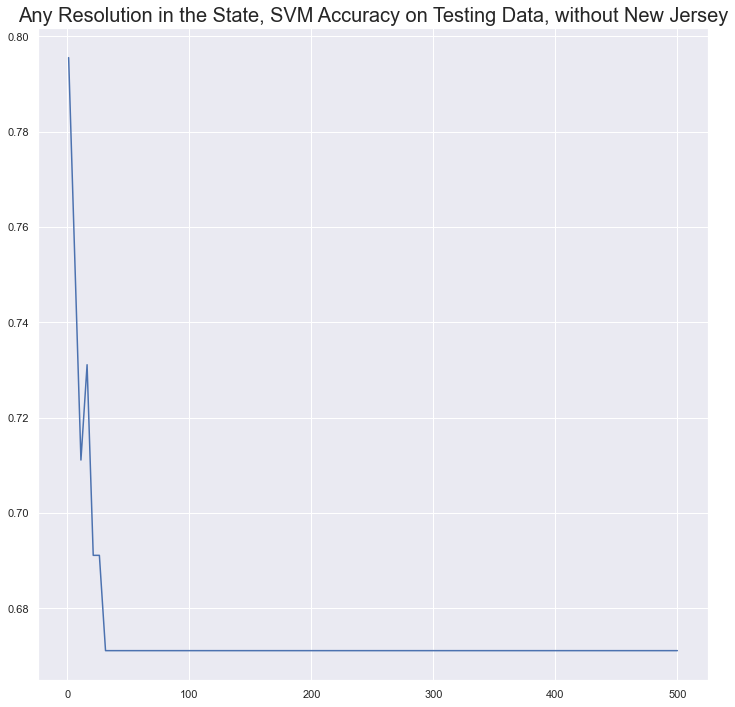

In [33]:
X2 = scale(statehate_2[["Hate crimes per cap", "Hate crimes AAPI per cap", "Hate groups per cap", "Hate Crime 5 Year Change Rate", "Conservative", "Liberal"]].values)


# Outcome: State resolution. This means that the state body passed at least one resolution against AAPI hate at the state level.
    
# Use an outcome of any state resolution
y = statehate_2["Any State Res"]

# Try different values of C
Cs = np.linspace(1,500,100)
# print(Cs)

# Using the 'cross_val_score' function, evaluate the accuracy of the SVM for different values of the parameter C.
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    svm_digits = svm.SVC(kernel='rbf', C = C, gamma='scale')
    scores = cross_val_score(estimator = svm_digits, X = X2, y = y, cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
    
    #print(round(C), scores.mean())
     
# Print max value of C and accuracy score
print("SVM: Any state resolution")
print("Max accuracy: C =", round(Cs[np.argmax(Accuracies)], 2), "Accuracy =", round(np.max(Accuracies),2))

# Plot accuracies
plt.plot(Cs,Accuracies)
plt.title("State resolution, SVM Accuracy on Testing Data, without New Jersey", fontsize=20)
plt.show()



# Outcome: any resolution in the state (at any level of government)
y = statehate_2["Any Res"]

# Try different values of C
Cs = np.linspace(1,500,100)
# print(Cs)

# Save the accuracies
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    svm_digits = svm.SVC(kernel='rbf', C = C, gamma='scale')
    scores = cross_val_score(estimator = svm_digits, X = X2, y = y, cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
    
    #print(round(C), scores.mean())
     
# Print max value of C and accuracy score
print("SVM: Any resolution at any level of government")
print("Max accuracy: C =", round(Cs[np.argmax(Accuracies)], 2), "Accuracy =", round(np.max(Accuracies),2))

# Plot accuracies
plt.plot(Cs,Accuracies)
plt.title("Any Resolution in the State, SVM Accuracy on Testing Data, without New Jersey", fontsize=20)
plt.show()


KNearestNeighbors

KNearestNeighbors: Any state resolution
Max accuracy: k = 14 Accuracy = 0.57


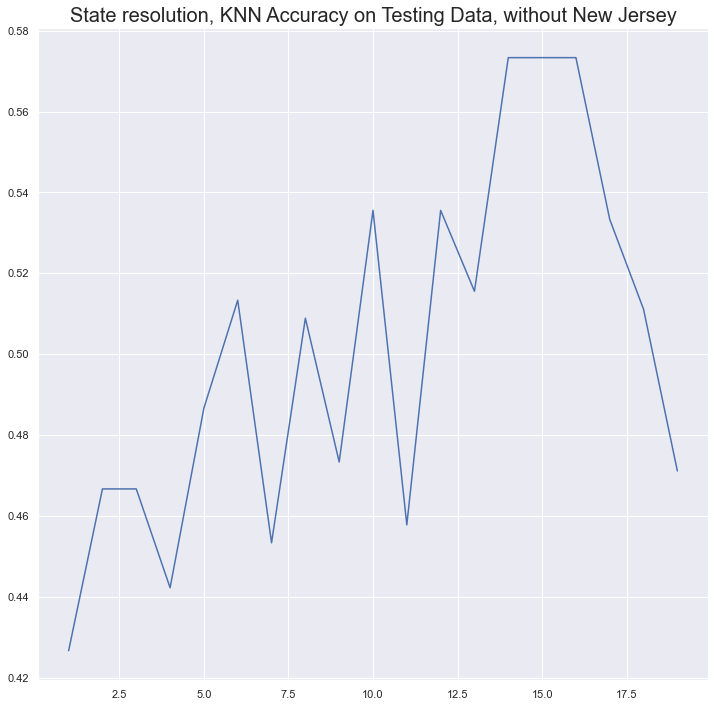

KNearestNeighbors: Any resolution (at any level of government)
Max accuracy: k = 5 Accuracy = 0.84


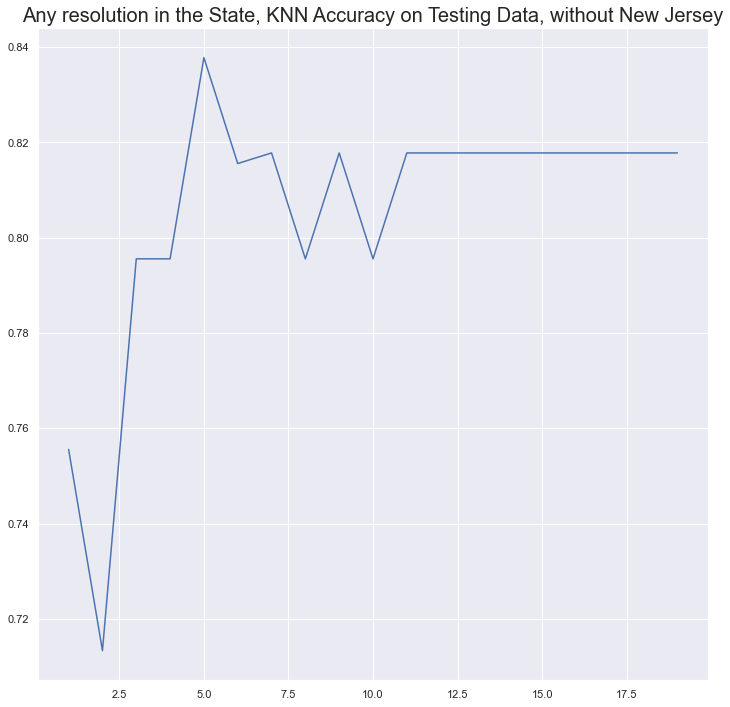

In [35]:
# Outcome: State resolution. This means that the state body passed at least one resolution against AAPI hate at the state level.
y = statehate_2["Any State Res"]

# Try different values of k
Ks = np.arange(1,20)
Accuracies = np.zeros(len(Ks))

# Save accuracies 
Accuracies = np.zeros(Ks.shape[0])
for i,k in enumerate(Ks): 
    ks_model = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(estimator = ks_model, X = X2, y = y, cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
# Print value of k wiyh the highest  accuracy score
print("KNearestNeighbors: Any state resolution")
print("Max accuracy: k =", round(Ks[np.argmax(Accuracies)], 2), "Accuracy =", round(np.max(Accuracies),2))
        
# Plot all values
plt.plot(Ks,Accuracies)
plt.title("State resolution, KNN Accuracy on Testing Data, without New Jersey", fontsize=20)
plt.show()



# Outcome: any resolution in the state (at any level of government)
y = statehate_2["Any Res"]

# Try different values of k
Ks = np.arange(1,20)
Accuracies = np.zeros(len(Ks))

Accuracies = np.zeros(Ks.shape[0])
for i,k in enumerate(Ks): 
    ks_model = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(estimator = ks_model, X = X2, y = y, cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
# Print value of k wiyh the highest  accuracy score
print("KNearestNeighbors: Any resolution (at any level of government)")
print("Max accuracy: k =", round(Ks[np.argmax(Accuracies)], 2), "Accuracy =", round(np.max(Accuracies),2))
        
# Plot all values
plt.plot(Ks,Accuracies)
plt.title("Any resolution in the State, KNN Accuracy on Testing Data, without New Jersey", fontsize=20)
plt.show()


**Interpretation:** Without the outlier of NJ, for the outcome of any state resolution, the SVM classifier and the KNearestNeighbors classifier both had worse accuracy (both had maximum accuracies of 0.57, c = 6.04 for SVM and k=14 for KNearestNeighbors). This is worse accuracy than the classifier models that contained the outlier NJ (max accuracy 0.6 for both models).

For the outcome of any resolution in the state (at any level of government), the SVM model without the outlier had the same maximum accuracy of 0.8 as the model with the outlier. The KNearestNeighbors classifier had a slightly higher accuracy of 0.84 (k = 5) as compared to an accuracy of 0.82 from the model with the outlier.

## Overall conclusion
Overall, both SVM and KNearestNeighbors classifiers do a good job of predicting whether a resolution will be passed in a state at any level of government. Both models, with and without New Jersey (the outlier), have an accuracy of 0.8-0.84.

The classifier models do not do a great job of predicting whether a state government will pass a resolution against AAPI hate at the state level. Both classifiers only had an accuracy of 0.6 with New Jersey and 0.57 without New Jersey.